In [2]:
import os
import pandas as pd
import numpy as np
from csv_processor import CsvProcessor



In [52]:
class MentalHealthProcessor(CsvProcessor):
    def clean(self):
        super().clean()

    def transform(self):
        return self

    def get_data(self):
        return self.df.copy()
        

    
    

In [53]:
data = MentalHealthProcessor.load_data('data/mental_health_dataset.csv').transform()

Original shape: (10000, 14)


In [54]:
data.describe()

,count,mean,std,min,5%,25%,50%,75%,95%,max
age,10000.0,41.55760,13.749581,18.0,20.0,30.0,41.5,53.0,63.0,65.0
stress_level,10000.0,5.57200,2.887741,1.0,1.0,3.0,6.0,8.0,10.0,10.0
sleep_hours,10000.0,6.47300,1.473944,3.0,4.0,5.5,6.5,7.5,8.9,10.0
physical_activity_days,10000.0,3.50570,2.282737,0.0,0.0,2.0,4.0,5.0,7.0,7.0
depression_score,10000.0,15.03990,8.990839,0.0,1.0,7.0,15.0,23.0,29.0,30.0
anxiety_score,10000.0,10.56180,6.322640,0.0,1.0,5.0,11.0,16.0,20.0,21.0
social_support_score,10000.0,50.11770,29.229278,0.0,5.0,25.0,50.0,76.0,95.0,100.0
productivity_score,10000.0,77.31221,14.061202,42.8,54.8,65.8,77.6,89.2,100.0,100.0


In [282]:
data.df.head()

,age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
0,56,Male,Employed,On-site,Yes,Yes,6,6.2,3,28,17,54,59.7,High
1,46,Female,Student,On-site,No,Yes,10,9.0,4,30,11,85,54.9,High
2,32,Female,Employed,On-site,Yes,No,7,7.7,2,24,7,62,61.3,Medium
3,60,Non-binary,Self-employed,On-site,No,No,4,4.5,4,6,0,95,97.0,Low
4,25,Female,Self-employed,On-site,Yes,Yes,3,5.4,0,24,12,70,69.0,High


In [56]:
data.missing_data()

,index,missing,missing_percentage


No se encuentran valores perdidos

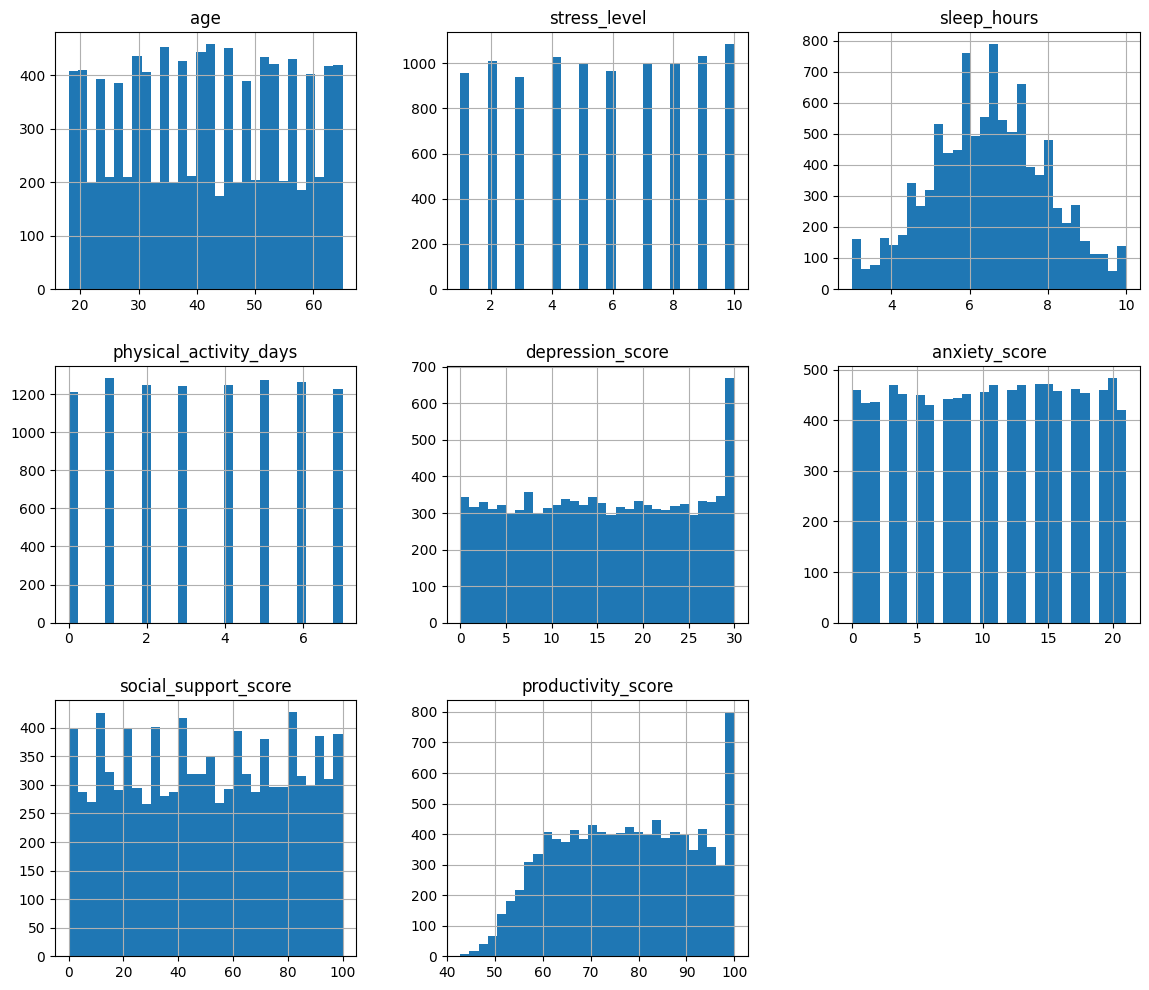

In [57]:
data.plot_distributions()

In [58]:
data.detect_outliers_iqr()

,variable,outliers,percentage
0,age,0,0.0
1,stress_level,0,0.0
2,sleep_hours,0,0.0
3,physical_activity_days,0,0.0
4,depression_score,0,0.0
5,anxiety_score,0,0.0
6,social_support_score,0,0.0
7,productivity_score,0,0.0


Tampoco se detectan outliers, lo que da una idea de lo equilibrados que están los datos por su naturaleza sintética.

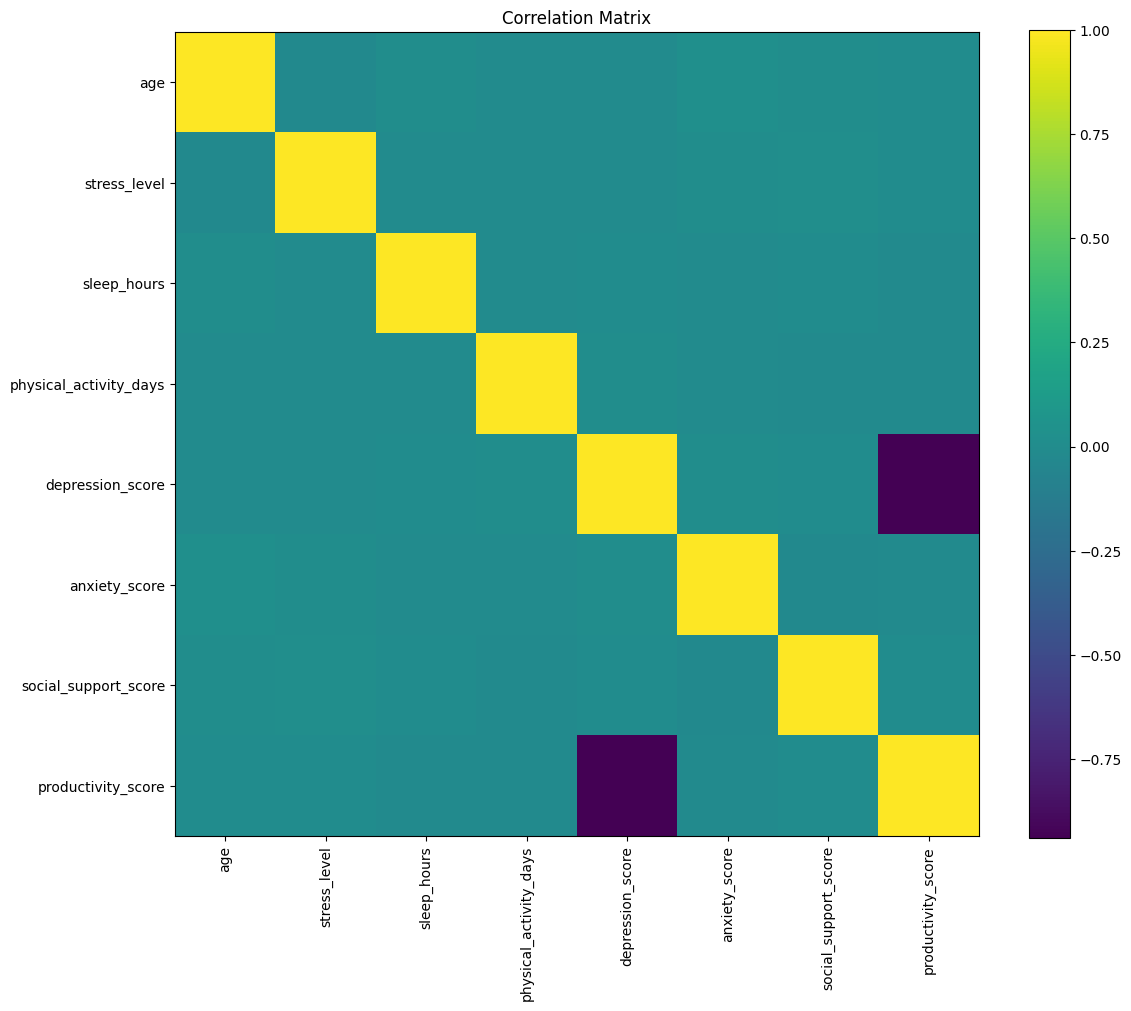

In [59]:
data.plot_correlation_matrix()

La matriz de correlaciones de las variables numéricas anticipa un reducido número de variables realmente representativas.

In [60]:
data.categorical_summary()

,variable,unique_values
0,gender,4
1,employment_status,4
2,work_environment,3
3,mental_health_history,2
4,seeks_treatment,2
5,mental_health_risk,3


# Transformaciones para las visualizaciones

## 1. Distribución por rango de edad y género

In [ ]:
# Histograma distribución por edades

In [141]:
# Transformaciones para visualización de distribución por edad

df = data.get_data()
bins = [15, 25, 35, 45, 55, 65, 200]
labels = ["15–24", "25–34", "35–44", "45–54", "55–64", "65+"]

df["age_range"] = pd.cut(df["age"], bins=bins, labels=labels, right=False)

df_grouped = (
    df.groupby(["gender", "age_range","employment_status"], observed=False)
      .size()
      .reset_index(name="count")
)
# Se convierte a formato "wide"
df_pivot = df_grouped.pivot_table(
    index=['age_range','gender'], 
    columns='employment_status', 
    values='count',
    observed=False
).reset_index()

df_grouped2 = df.groupby("age_range", observed=False).size().reset_index(name="count") # Para el histograma de  age_range


In [144]:
df_grouped2.to_excel('age_distribution.xlsx', index=False)

In [138]:
df_pivot.to_excel('age_gender_distribution.xlsx', index=False)

## 2. Regresión logística, predicción de high mental health risk

In [251]:
from sklearn.preprocessing import StandardScaler

df_model = df.copy()

# Variable objetivo binaria: 1 = High, 0 = Low o Medium
df_model["risk_high"] = (df_model["mental_health_risk"] == "High").astype(int)

numerical_features = [
    "stress_level",
    "sleep_hours",
    "anxiety_score",
    "depression_score",
    "productivity_score",
    "physical_activity_days"
]

categorical_features = ["gender", "employment_status", "work_environment", "mental_health_history", "seeks_treatment"]
df_dummies = pd.get_dummies(df_model[categorical_features], drop_first=True) # Drop first para evitar colinealida

X_num = df_model[numerical_features]
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)
X = np.concatenate([X_num_scaled, df_dummies.values], axis=1)

y = df_model["risk_high"]


In [252]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500)
model.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [253]:
import numpy as np

coef = model.coef_[0]
feature_names = numerical_features + list(df_dummies.columns)
results = pd.DataFrame({"variable": feature_names,"coefficient": coef,"odds_ratio": np.exp(coef)}).sort_values("odds_ratio", ascending=False)

In [254]:
print(results)

                           variable  coefficient     odds_ratio
3                  depression_score    13.520427  744469.182320
2                     anxiety_score     9.951894   20991.943801
15              seeks_treatment_Yes     0.167128       1.181906
6                       gender_Male     0.117210       1.124356
5            physical_activity_days     0.027949       1.028343
0                      stress_level     0.003228       1.003233
9   employment_status_Self-employed     0.003199       1.003205
1                       sleep_hours    -0.020473       0.979735
10        employment_status_Student    -0.049362       0.951836
13          work_environment_Remote    -0.051449       0.949853
14        mental_health_history_Yes    -0.054514       0.946945
12         work_environment_On-site    -0.106529       0.898949
8          gender_Prefer not to say    -0.126282       0.881367
7                 gender_Non-binary    -0.145497       0.864592
11     employment_status_Unemployed    -

In [255]:
results.to_csv("logistic_importance.csv", index=False)  # Para el gráfico de barras de coeficientes y la tabla de resultados

# Heatmap

In [281]:
numerical_vars = [
    'age', 'stress_level', 'sleep_hours', 'physical_activity_days',
    'depression_score', 'anxiety_score', 'social_support_score',
    'productivity_score'
]


categorical_vars = [
    'employment_status', 'work_environment', 'mental_health_history', 'seeks_treatment', 'mental_health_risk'
]


df_dummies = pd.get_dummies(df[categorical_vars], drop_first=True)


df_full = pd.concat([df[numerical_vars], df_dummies], axis=1)
corr_matrix = df_full.corr()


corr_long = corr_matrix.reset_index().melt(id_vars='index')
corr_long.columns = ['variable_x','variable_y','correlation']


corr_long.to_csv('correlation_heatmap_full_flourish.csv', index=False)

print(corr_long.head())



               variable_x variable_y  correlation
0                     age        age     1.000000
1            stress_level        age    -0.015630
2             sleep_hours        age     0.008407
3  physical_activity_days        age    -0.003887
4        depression_score        age    -0.001486
